<small>
!/usr/bin/env python
 coding: utf-8

Basic Steps

1. Run a baseline training script to build a speech commands model.
2. Add in your custom word to the training and test/validation sets.
   - Modify labels, shape of your output tensor in the model.
   - Make sure that feature extractor for the model aligns with the feature extractor 
     used in the arduino code.
3. Re-train model. => TF Model using floating-point numbers, that recognizes Google word and custom word.
4. Quantize the model and convert to TFlite. => keyword_model.tflite file
5. Convert tflite to .c file, using xxd => model_data.cc
6. Replace contents of existing micro_features_model.cpp with output of xxd.

All of the above steps are done in this notebook for the commands 'left', 'right'.

7. In micro_speech.ino, modify micro_op_resolver (around line 80) to add any necessary operations (DIFF_FROM_LECTURE)
8. In micro_features_model_settings.h, modify kSilenceIndex and kUnknownIndex, depending on where you have them in commands.  
   - Commands = ['left', 'right', '_silence', '_unknown'] => kSilenceIndex=2, kUnknownIndex=3
9. In micro_features_model_settings.cpp, modify kCategoryLabels to correspond to commands in this script.
10. In micro_features_micro_model_settings.h, set kFeatureSliceDurationMs, kFeatureSliceStrideMs to match what is passed to microfrontend as window_size, window_step, respectively.
11. Rebuild Arduino program, run it, recognize the two target words.
12. Experiment with model architecture, training parameters/methods, augmentation, more data-gathering, etc.
 

You can download the data set with this command line (or just a browser):
 
`wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz `</small>


In [637]:
def in_notebook():
  """
  Test if we are in a python script vs jupyter notebook.
  Returns True if called in a jupyter notebook, false if called in a standard python file
  taken from https://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook
  """
  import __main__ as main
  return not hasattr(main, '__file__')

In [638]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models, regularizers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time

if in_notebook:
  from tqdm.notebook import tqdm
else:
  from tqdm import tqdm 

import os
import pathlib

from datetime import datetime as dt

from IPython import display

import platform


# Future Aidan: The model overfits like a mf, tune model complexity or balance dataset (look into silence & unknown classes)
# Target Custom Word is lean

2.10.0


In [639]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [640]:
# Define range of 16-bit integers
i16min = -2**15
i16max = 2**15-1
fsamp = 16000 # sampling rate
wave_length_ms = 1000 # 1000 => 1 sec of audio
wave_length_samps = int(wave_length_ms*fsamp/1000)

# you can change these next three
window_size_ms = 64 
window_step_ms = 48
num_filters = 32
batch_size = 32
use_microfrontend = True # recommended, but you can use another feature extractor if you like

## uncomment exactly one of these 
dataset = 'mini-speech'
# dataset = 'full-speech-files' # use the full speech commands stored as files 

# Custom word - Lean

commands = ['up', 'down'] ## Change this line for your custom keywords

# limit the instances of each command in the training set to simulate limited data
limit_positive_samples = True
max_wavs_0 = 200  # use no more than ~ samples of commands[0]
max_wavs_1 = 200  # use no more than ~ samples of commands[1]

silence_str = "_silence"  # label for <no speech detected>
unknown_str = "_unknown"  # label for <speech detected but not one of the target words>
EPOCHS = 2

print(f"FFT window length = {int(window_size_ms * fsamp / 1000)}")

might_be = {True:"IS", False:"IS NOT"} # useful for formatting conditional sentences

# Apply the frontend to an example signal.


FFT window length = 1024


In [641]:
if dataset == 'mini-speech':
  data_dir = pathlib.Path(os.path.join(os.getenv("USERPROFILE"), 'Desktop/UNCC/Github/ML-for-IoT/HW5/data/mini_speech_commands'))
  if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True, cache_dir='.', cache_subdir='data'
                           )
  # commands = np.array(tf.io.gfile.listdir(str(data_dir))) # if you want to use all the command words
  # commands = commands[commands != 'README.md']
elif dataset == 'full-speech-files':
  # data_dir = '/dfs/org/Holleman-Coursework/data/speech_dataset'
  data_dir = pathlib.Path(os.path.join(os.getenv("USERPROFILE"), 'Desktop/UNCC/Github/ML-for-IoT/HW5/data', 'speech_commands_files_0.2'))
else:
  raise RuntimeError('dataset should either be "mini-speech" or "full-speech-files"')

In [642]:
data_dir

WindowsPath('C:/Users/aidan_000/Desktop/UNCC/Github/ML-for-IoT/HW5/data/mini_speech_commands')

In [643]:
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'up', 'down']


In [644]:
if dataset == 'mini-speech' or dataset == 'full-speech-files':
    # filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav') 
    # filenames = tf.io.gfile.glob(str(data_dir) + os.sep + '*' + '/' + '*.wav')
    filenames = tf.io.gfile.glob(os.path.join(str(data_dir), '*', '*.wav'))
    
    # with the next commented-out line, you can choose only files for words in label_list
    # filenames = tf.concat([tf.io.gfile.glob(str(data_dir) + '/' + cmd + '/*') for cmd in label_list], 0)
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    # print('Number of examples per label:',
    #       len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
    print('Example file tensor:', filenames[0])

Number of total examples: 8000
Example file tensor: tf.Tensor(b'C:\\Users\\aidan_000\\Desktop\\UNCC\\Github\\ML-for-IoT\\HW5\\data\\mini_speech_commands\\up\\b7a6f709_nohash_0.wav', shape=(), dtype=string)


In [645]:
# Not really necessary, but just look at a few of the files to make sure that 
# they're the correct files, shuffled, etc.

# for i in range(10):
#     print(filenames[i].numpy().decode('utf8'))

In [646]:
if dataset == 'mini-speech':
  print('Using mini-speech')
  num_train_files = int(0.8*num_samples)
  num_val_files = int(0.1*num_samples)
  num_test_files = num_samples - num_train_files - num_val_files
  train_files = filenames[:num_train_files]
  val_files = filenames[num_train_files: num_train_files + num_val_files]
  test_files = filenames[-num_test_files:]
elif dataset == 'full-speech-files':  
  # the full speech-commands set lists which files are to be used
  # as test and validation data; train with everything else
  fname_val_files = os.path.join(data_dir, 'validation_list.txt')    
  with open(fname_val_files) as fpi_val:
    val_files = fpi_val.read().splitlines()
  # validation_list.txt only lists partial paths
  val_files = [os.path.join(data_dir, fn) for fn in val_files]
  fname_test_files = os.path.join(data_dir, 'testing_list.txt')
  with open(fname_test_files) as fpi_tst:
    test_files = fpi_tst.read().splitlines()
  # testing_list.txt only lists partial paths
  test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]    
    
  if os.sep != '/': 
    # the files validation_list.txt and testing_list.txt use '/' as path separator
    # if we're on a windows machine, replace the '/' with the correct separator
    val_files = [fn.replace('/', os.sep) for fn in val_files]
    test_files = [fn.replace('/', os.sep) for fn in test_files] 

  # convert the TF tensor filenames into an array of strings so we can use basic python constructs
  train_files = [f.decode('utf8') for f in filenames.numpy()]
  # don't train with the _background_noise_ files; exclude when directory name starts with '_'
  train_files = [f for f in train_files if f.split(os.sep)[-2][0] != '_']
  # validation and test files are listed explicitly in *_list.txt; train with everything else
  train_files = list(set(train_files) - set(test_files) - set(val_files))
   
elif dataset == 'full-speech-ds':  
    print("Using full-speech-ds. This is in progress.  Good luck!")
else:
  raise ValueError("dataset must be either full-speech-files, full-speech-ds or mini-speech")

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

# max_samples_per_command = {
#     'up': 25,  # Limit for 'up' command
#     'down': 250  # Limit for 'down' command
# }

# # Initialize dictionaries to keep track of selected samples for each command
# selected_samples_per_command = {command: 0 for command in commands}

# # Initialize lists to store selected files for training
# train_files_selected = []

# # Iterate through all files and select samples based on the limits
# for filename_tensor in train_files:
#     filename = filename_tensor.numpy().decode('utf-8')  # Convert tensor to string
#     for command in commands:
#         if command in filename and selected_samples_per_command[command] < max_samples_per_command.get(command, float('inf')):
#             train_files_selected.append(filename_tensor)
#             selected_samples_per_command[command] += 1
#             break

# # Print the sizes of the new training set
# print('New training set size:', len(train_files_selected))

Using mini-speech
Training set size 6400
Validation set size 800
Test set size 800


In [647]:
if limit_positive_samples:
  train_files = list(train_files)
  random.shuffle(train_files)
  num_files_cmd0 = 0
  num_files_cmd1 = 0
  # elements of train_files look like this:
  # '/path/to/data/speech_commands_0_2_root/right/196e84b7_nohash_0.wav'
  # so if we split on '/' (or '\' in windows), the 2nd to last element is the label
  
  for idx,f in enumerate(train_files):
    if f.numpy().decode('utf-8').split(os.sep)[-2] == commands[0]:
      if num_files_cmd0 >= max_wavs_0:
        train_files.pop(idx)
      else:
        num_files_cmd0 += 1
    elif f.numpy().decode('utf-8').split(os.sep)[-2] == commands[1]:
      if num_files_cmd1 >= max_wavs_1:
        train_files.pop(idx)
      else:
        num_files_cmd1 += 1

In [648]:
print(train_files[:5])
print(val_files[:5])
print(test_files[:5])

[<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\aidan_000\\Desktop\\UNCC\\Github\\ML-for-IoT\\HW5\\data\\mini_speech_commands\\stop\\44b5720d_nohash_0.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\aidan_000\\Desktop\\UNCC\\Github\\ML-for-IoT\\HW5\\data\\mini_speech_commands\\no\\36de13e1_nohash_0.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\aidan_000\\Desktop\\UNCC\\Github\\ML-for-IoT\\HW5\\data\\mini_speech_commands\\up\\c0c701f1_nohash_0.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\aidan_000\\Desktop\\UNCC\\Github\\ML-for-IoT\\HW5\\data\\mini_speech_commands\\yes\\e32ff49d_nohash_0.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\aidan_000\\Desktop\\UNCC\\Github\\ML-for-IoT\\HW5\\data\\mini_speech_commands\\down\\17cc40ee_nohash_0.wav'>]
tf.Tensor(
[b'C:\\Users\\aidan_000\\Desktop\\UNCC\\Github\\ML-for-IoT\\HW5\\data\\mini_speech_commands\\go\\763188c4_nohash_1.wav'
 b'C:\\Users\\aidan_000\\Desktop\\UNCC\\Github\\

In [649]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [650]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return  label # parts[-2]

In [651]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [652]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram

# Function to convert each waveform in a set into a spectrogram, then convert those
# back into a dataset using `from_tensor_slices`.  (We should be able to use 
# `wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).

In [653]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))

In [654]:
def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:] 
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:    
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))
  return output_ds

In [655]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

About to create spectrograms from 5430 waves
 5250 wavs processed

In [656]:
def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)    
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)

In [657]:
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

In [658]:
def count_labels(dataset):
    counts = {}
    for sample in dataset: # sample will be a tuple: (input, label) or (input, label, weight)
        lbl = sample[1]
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [659]:
def is_batched(ds):
    ## This is probably not very robust
    try:
        ds.unbatch()  # does not actually change ds. For that we would ds=ds.unbatch()
    except:
        return False # we'll assume that the error on unbatching is because the ds is not batched.
    else:
        return True  # if we were able to unbatch it then it must have been batched (??)

In [660]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  """
  preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None)
  files -- list of files
  noisy_reps_of_known either None, or a list of rms noise levels
      For every target word in the data set, 1 copy will be created with each level 
      of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
  """
  if num_silent is None:
    num_silent = int(0.2*len(files))+1
  print(f"Processing {len(files)} files")
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
       waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  if num_silent > 0:
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
                                            rms_noise_range=[0.01,0.2], 
                                            silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  print(f"Added {num_silent} silent wavs and ?? noisy wavs")
  num_waves = 0
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [661]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

We have 5430/800/800 training/validation/test files


In [662]:
# train_files = train_files[0:10000] for a quick test run

In [663]:
t0 = time.time()
# train_ds is already done

train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25, .1, .1, .1])

val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
t1 = time.time()
print(f"Took time: {t1-t0}")

Processing 5430 files
Added 1087 silent wavs and ?? noisy wavs
About to create spectrograms from 11637 waves
 11500 wavs processedProcessing 800 files
Added 161 silent wavs and ?? noisy wavs
About to create spectrograms from 961 waves
 750 wavs processedProcessing 800 files
Added 161 silent wavs and ?? noisy wavs
About to create spectrograms from 961 waves
 750 wavs processedTook time: 61.72838115692139


In [664]:
train_ds = train_ds.shuffle(int(len(train_files)*1.2))
val_ds = val_ds.shuffle(int(len(val_files)*1.2))
test_ds = test_ds.shuffle(int(len(test_files)*1.2))

train_counts = count_labels(train_ds)

print("Training dataset label distribution:")
for idx in train_counts:
    print(f"{label_list[idx]}: {train_counts[idx]}")

Training dataset label distribution:
_unknown: 4790
down: 2862
up: 2898
_silence: 1087


In [665]:
if not is_batched(train_ds):
    train_ds = train_ds.batch(batch_size)
if not is_batched(val_ds):
    val_ds = val_ds.batch(batch_size)
if not is_batched(test_ds):
    test_ds = test_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [666]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram.shape[1:]  
print('Input shape:', input_shape)
num_labels = len(label_list)

Input shape: (20, 32, 1)


In [667]:
def build_model_no_reg(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, activation='relu'), # 32 filters, 3x3 kernel
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.1), # Dropout rate of <0.5 for input/output layers
        layers.BatchNormalization(),
      
        layers.Conv2D(32, 3, activation='relu'), # 64 filters, 3x3 kernel
        
        layers.BatchNormalization(),
      
        layers.Conv2D(64, 3, activation='relu'), # 128 filters, 3x3 kernel
        layers.BatchNormalization(),

        layers.Conv2D(128, 3, activation='relu'), # 256 filters, 3x3 kernel
        layers.BatchNormalization(),

        layers.Conv2D(128, 3, activation='relu'), # 256 filters, 3x3 kernel
        layers.BatchNormalization(),
      
        layers.GlobalMaxPooling2D(),
        layers.Dropout(0.2),
        layers.Dense(num_labels),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    return model

In [668]:
def build_model_l1(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.l1(0.01)), # 32 filters, 3x3 kernel
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.1), # Dropout rate of <0.5 for input/output layers
        layers.BatchNormalization(),
      
        layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l1(0.01)), # 64 filters, 3x3 kernel
        
        layers.BatchNormalization(),
      
        layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l1(0.01)), # 128 filters, 3x3 kernel
        layers.BatchNormalization(),

        layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l1(0.01)), # 256 filters, 3x3 kernel
        layers.BatchNormalization(),

        layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l1(0.01)), # 256 filters, 3x3 kernel
        layers.BatchNormalization(),
      
        layers.GlobalMaxPooling2D(),
        layers.Dropout(0.2),
        layers.Dense(num_labels),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    return model

In [669]:
def build_model_l2(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 32 filters, 3x3 kernel
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.1), # Dropout rate of <0.5 for input/output layers
        layers.BatchNormalization(),
      
        layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 64 filters, 3x3 kernel
        
        layers.BatchNormalization(),
      
        layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 128 filters, 3x3 kernel
        layers.BatchNormalization(),

        layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 256 filters, 3x3 kernel
        layers.BatchNormalization(),

        layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 256 filters, 3x3 kernel
        layers.BatchNormalization(),
      
        layers.GlobalMaxPooling2D(),
        layers.Dropout(0.2),
        layers.Dense(num_labels),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    return model

In [670]:
print('Input shape:', input_shape)
model = build_model_no_reg(input_shape)
model_l1 = build_model_l1(input_shape)
model_l2 = build_model_l2(input_shape)

model.summary()    
model_l1.summary()
model_l2.summary()  

Input shape: (20, 32, 1)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_180 (Conv2D)         (None, 18, 30, 16)        160       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 9, 15, 16)        0         
 g2D)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 9, 15, 16)         0         
                                                                 
 batch_normalization_180 (Ba  (None, 9, 15, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_181 (Conv2D)         (None, 7, 13, 32)         4640      
                                                                 
 batch_normalization_181 (Ba

In [671]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS)

history = model_l1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS)

history = model_l2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS)

Epoch 1/2
364/364 [==============================] - 3s 6ms/step - loss: 0.8904 - accuracy: 0.6510 - val_loss: 0.7480 - val_accuracy: 0.7742
Epoch 2/2
364/364 [==============================] - 3s 8ms/step - loss: 0.6315 - accuracy: 0.7356 - val_loss: 0.5618 - val_accuracy: 0.8137
Epoch 1/2
364/364 [==============================] - 3s 6ms/step - loss: 16.3059 - accuracy: 0.6209 - val_loss: 4.0448 - val_accuracy: 0.7326
Epoch 2/2
364/364 [==============================] - 2s 6ms/step - loss: 3.5227 - accuracy: 0.6439 - val_loss: 2.9167 - val_accuracy: 0.7242
Epoch 1/2
364/364 [==============================] - 3s 6ms/step - loss: 2.8920 - accuracy: 0.6675 - val_loss: 2.1205 - val_accuracy: 0.6660
Epoch 2/2
364/364 [==============================] - 2s 6ms/step - loss: 1.4594 - accuracy: 0.7355 - val_loss: 1.0451 - val_accuracy: 0.7908


In [672]:
def calculate_sparsity(model):
    sparsity = []
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
            weights = layer.get_weights()[0]
            threshold = 0.01 * np.max(np.abs(weights))
            sparsity.append(np.sum(np.abs(weights) < threshold) / weights.size)
    return sparsity

sparsity_no_reg = calculate_sparsity(model)
sparsity_l1 = calculate_sparsity(model_l1)
sparsity_l2 = calculate_sparsity(model_l2)

# print(sparsity_no_reg)
# print(sparsity_l1)
# print(sparsity_l2)

In [673]:
date_str = dt.now().strftime("%d%b%Y_%H%M").lower()
print(f"Completed training at {date_str}")

Completed training at 19apr2024_2127


In [674]:
model_file_name = f"kws_model.h5" 
print(f"Saving model to {model_file_name}")
model.save(model_file_name, overwrite=True)

Saving model to kws_model.h5


In [675]:
## Measure test-set accuracy manually and get values for confusion matrix
test_audio = []
test_labels = []
if is_batched(test_ds):
  was_batched=True
  test_ds = test_ds.unbatch()
else:
  was_batched=False
for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

model_out = model.predict(test_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.1%}')
if was_batched:
  test_ds = test_ds.batch(32)

31/31 [==============================] - 0s 2ms/step
Test set accuracy: 81.1%


In [676]:
## Measure test-set accuracy with the keras built-in function
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

31/31 - 0s - loss: 0.6063 - accuracy: 0.8106 - 110ms/epoch - 4ms/step


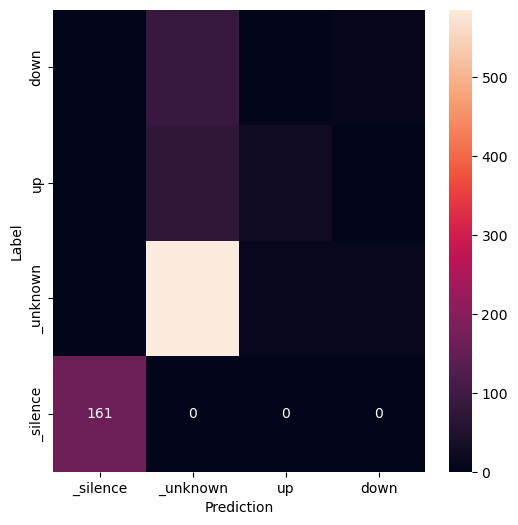

In [677]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [678]:
tpr = np.nan*np.zeros(len(label_list))
fpr = np.nan*np.zeros(len(label_list))
fnr = np.nan*np.zeros(len(label_list))

for i in range(4):
    tpr[i]  = confusion_mtx[i,i] / np.sum(confusion_mtx[i,:])
    fpr[i] = (np.sum(confusion_mtx[:,i]) - confusion_mtx[i,i]) / \
      (np.sum(confusion_mtx) - np.sum(confusion_mtx[i,:]))
    fnr[i]  = (np.sum(confusion_mtx[i,:]) - confusion_mtx[i,i]) / np.sum(confusion_mtx[i,:])
    print(f"True/False positive rate for '{label_list[i]:9}' = {tpr[i]:.3} / {fpr[i]:.3}")
    print(f"False negative rate for '{label_list[i]:9}' = {fnr[i]:.3}")

True/False positive rate for '_silence ' = 1.0 / 0.00125
False negative rate for '_silence ' = 0.0
True/False positive rate for '_unknown ' = 0.964 / 0.45
False negative rate for '_unknown ' = 0.0362
True/False positive rate for 'up       ' = 0.24 / 0.0127
False negative rate for 'up       ' = 0.76
True/False positive rate for 'down     ' = 0.0938 / 0.0127
False negative rate for 'down     ' = 0.906


In [679]:
## Measure test-set accuracy manually and get values for confusion matrix
test_audio = []
test_labels = []
if is_batched(test_ds):
  was_batched=True
  test_ds = test_ds.unbatch()
else:
  was_batched=False
for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

model_out = model_l1.predict(test_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.1%}')
if was_batched:
  test_ds = test_ds.batch(32)

31/31 [==============================] - 0s 2ms/step
Test set accuracy: 72.9%


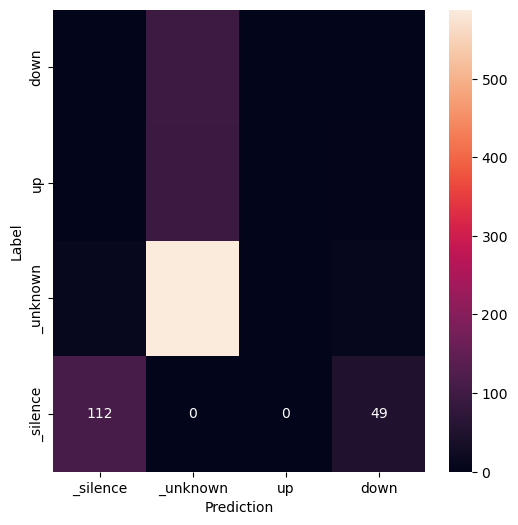

In [680]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [681]:
tpr = np.nan*np.zeros(len(label_list))
fpr = np.nan*np.zeros(len(label_list))
fnr = np.nan*np.zeros(len(label_list))

for i in range(4):
    tpr[i]  = confusion_mtx[i,i] / np.sum(confusion_mtx[i,:])
    fpr[i] = (np.sum(confusion_mtx[:,i]) - confusion_mtx[i,i]) / \
      (np.sum(confusion_mtx) - np.sum(confusion_mtx[i,:]))
    fnr[i]  = (np.sum(confusion_mtx[i,:]) - confusion_mtx[i,i]) / np.sum(confusion_mtx[i,:])
    print(f"True/False positive rate for '{label_list[i]:9}' = {tpr[i]:.3} / {fpr[i]:.3}")
    print(f"False negative rate for '{label_list[i]:9}' = {fnr[i]:.3}")

True/False positive rate for '_silence ' = 0.696 / 0.015
False negative rate for '_silence ' = 0.304
True/False positive rate for '_unknown ' = 0.967 / 0.524
False negative rate for '_unknown ' = 0.0329
True/False positive rate for 'up       ' = 0.0 / 0.00116
False negative rate for 'up       ' = 1.0
True/False positive rate for 'down     ' = 0.0104 / 0.0717
False negative rate for 'down     ' = 0.99


In [682]:
## Measure test-set accuracy manually and get values for confusion matrix
test_audio = []
test_labels = []
if is_batched(test_ds):
  was_batched=True
  test_ds = test_ds.unbatch()
else:
  was_batched=False
for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

model_out = model_l2.predict(test_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.1%}')
if was_batched:
  test_ds = test_ds.batch(32)

31/31 [==============================] - 0s 2ms/step
Test set accuracy: 79.6%


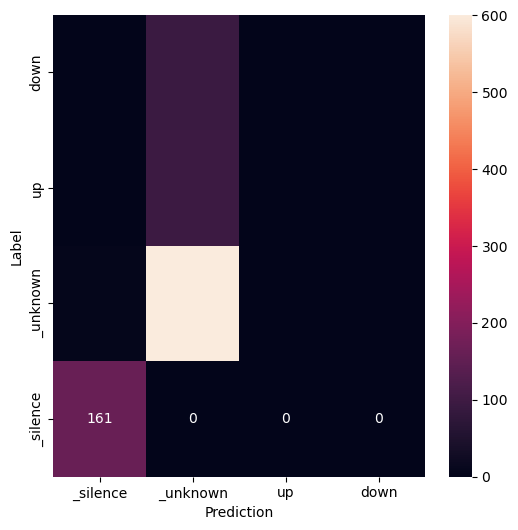

In [683]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [684]:
tpr = np.nan*np.zeros(len(label_list))
fpr = np.nan*np.zeros(len(label_list))
fnr = np.nan*np.zeros(len(label_list))

for i in range(4):
    tpr[i]  = confusion_mtx[i,i] / np.sum(confusion_mtx[i,:])
    fpr[i] = (np.sum(confusion_mtx[:,i]) - confusion_mtx[i,i]) / \
      (np.sum(confusion_mtx) - np.sum(confusion_mtx[i,:]))
    fnr[i]  = (np.sum(confusion_mtx[i,:]) - confusion_mtx[i,i]) / np.sum(confusion_mtx[i,:])
    print(f"True/False positive rate for '{label_list[i]:9}' = {tpr[i]:.3} / {fpr[i]:.3}")
    print(f"False negative rate for '{label_list[i]:9}' = {fnr[i]:.3}")

True/False positive rate for '_silence ' = 1.0 / 0.01
False negative rate for '_silence ' = 0.0
True/False positive rate for '_unknown ' = 0.988 / 0.53
False negative rate for '_unknown ' = 0.0115
True/False positive rate for 'up       ' = 0.0104 / 0.0
False negative rate for 'up       ' = 0.99
True/False positive rate for 'down     ' = 0.0208 / 0.00116
False negative rate for 'down     ' = 0.979


In [685]:
info_file_name = model_file_name.split('.')[0] + '.txt'
with open(info_file_name, 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")
    fpo.write(f"Test set accuracy =  {test_acc:.1%}\n")
    for i in range(4):
        fpo.write(f"tpr_{label_list[i]:9} = {tpr[i]:.3}\n")
        fpo.write(f"fpr_{label_list[i]:9} = {fpr[i]:.3}\n")

In [686]:
print(f"Wrote description to {info_file_name}")

Wrote description to kws_model.txt


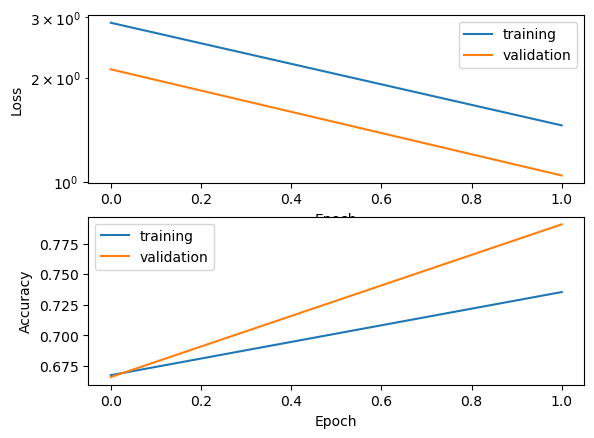

<Figure size 640x480 with 0 Axes>

In [687]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig('training_curves.png')

In [688]:
## Measure test-set accuracy with the keras built-in function
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

31/31 - 0s - loss: 0.6063 - accuracy: 0.8106 - 132ms/epoch - 4ms/step


ds_labels[0] = 2
<class 'list'>
31/31 [==============================] - 0s 2ms/step


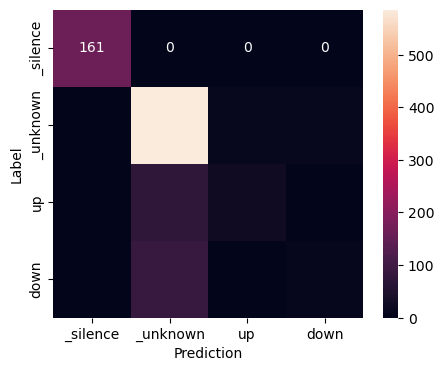

<Figure size 640x480 with 0 Axes>

: 

In [689]:
def get_confusion_matrix(dset, model):
    # there is probably a cleaner way to do this using y_pred = model.predict(dset)
    ds_audio = []
    ds_labels = []

    if is_batched(dset):
      dset = dset.unbatch()
  
    for sample in dset:
      audio, label = sample[0], sample[1]
      ds_audio.append(audio.numpy())
      ds_labels.append(label.numpy())

    print(f"ds_labels[0] = {ds_labels[0]}")
    print(type(ds_labels))

    ds_labels = np.array(ds_labels)
    ds_audio = np.array(ds_audio)

    model_out = model.predict(ds_audio)
    y_pred = np.argmax(model_out, axis=1)
    y_true = ds_labels

    # ds_acc = sum(y_pred == y_true) / len(y_true)
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
    return confusion_mtx

# print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = get_confusion_matrix(test_ds, model)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
plt.savefig('test_set_confusion_matrix.png')
